In [1]:
import sys
import cv2
import os
from sys import platform
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dir_path = '/root/final/main'
sys.path.append('/root/final/main')
sys.path.append('/usr/local/python/openpose')
from openpose import *

In [3]:
params = dict()
params["logging_level"] = 3
params["output_resolution"] = "-1x-1"
params["net_resolution"] = "-1x368"
params["model_pose"] = "BODY_25"
params["alpha_pose"] = 0.6
params["scale_gap"] = 0.25
params["scale_number"] = 1
params["render_threshold"] = 0.05
# If GPU version is built, and multiple GPUs are available, set the ID here
params["num_gpu"] = 1
params["num_gpu_start"] = 0
params["disable_blending"] = False
# Ensure you point to the correct path where models are located
params["default_model_folder"] = "/root/final/openpose/models/"
# Construct OpenPose object allocates GPU memory
openpose = OpenPose(params)

In [4]:
#test_video1
test1 = "barbell_curls_true"
test2 = "barbell_curls_wrong"
test3 = "dumbbell_lateral_raise_true"
test4 = "dumbbell_lateral_raise_wrong"
test5 = "dumbbell_lateral_raise_whole_true"
test6 = "dumbbell_lateral_raise_whole_wrong1"
test7 = "dumbbell_lateral_raise_whole_wrong2"
test8 = "dumbbell_rowing_true"
test9 = "dumbbell_rowing_wrong"
test10 = "rope_down_true"
test11 = "rope_down_wrong"
test12 = "squat_true"
test13 = "squat_wrong"

#test_video2
test14 = "barbell_curls_test1"
test15 = "barbell_curls_test2" 
test16 = "barbell_curls_test3"
test17 = "dumbbell_lateral_raise_test1"
test18 = "dumbbell_lateral_raise_test2"
test19 = "dumbbell_lateral_raise_test3"
test20 = "dumbbell_rowing_test"
test21 = "squat_test1"
test22 = "squat_test2"


# the path of the video
#input_path = "/root/final/main/test_video/test_video1/" # for test_video1
#!!if you want to use videos in test_video2, comment the above line and use the following one
input_path = "/root/final/main/test_video/test_video1/" #for test_video2


input_video = test8
input_type = ".mp4"
cap = cv2.VideoCapture(input_path+input_video+input_type)
# create the output folder
folder = os.path.exists("output_video/"+ input_video) 
if not folder:                  
    os.makedirs("output_video/"+ input_video) 

def get_angle(vec1,vec2):
    # return the angle of vector one to vector two in clockwise direction
    #vec1 and vec2 are list
    x = np.array(vec1)
    y = np.array(vec2)
    #lenth
    Lx = np.sqrt(x.dot(x))
    Ly = np.sqrt(y.dot(y))
    cos_angle = x.dot(y)/(Lx*Ly)
    if cos_angle > 1:
        cos_angle = 1
    angle = np.arccos(cos_angle)
    angle2 = angle*360/2/np.pi
    crossdd = np.cross(x,y)
    if (crossdd <= 0):
        return -angle2
    else:
        return angle2
    

# here determine whether is right or left hand exercising
def which_arm(L_point,R_point):
    if L_point < R_point:
        return 0
    else:
        return 1
#(0 for left, 1 for right)        
  
    
count = 0
theta = 0 # 起始预计的夹角
body_angle = []
upper_arm = []
between_arm = []
index_count = []
while(cap.isOpened()):
    ret, frame = cap.read()  
    if frame is None:
        break
    
    # no need shift for this image for test_8
    if (input_path == "/root/final/main/test_video/test_video2/"):
        frame = cv2.transpose(frame)
        frame = cv2.flip(frame,1)
    
    #return the keypoints and rendered output images
    keypoints, output_image = openpose.forward(frame, True)
    # Print the human pose keypoints, i.e., a [#people x #keypoints x 3]-dimensional numpy object with the keypoints of all the people on that image
    
    #在开始时候判定运动手
    if count==0:
        flag = which_arm(keypoints[0][4][1],keypoints[0][7][1])
        
    # 得到躯干和水平线的夹角    
    H18 = list(keypoints[0][8][0:2]-keypoints[0][1][0:2])
    Hhorizon = [-1,0]
    body_angle.append(get_angle(H18,Hhorizon))
    
    
    #存储右臂的夹角
    if flag == 1:
        L23 = list(keypoints[0][3][0:2]-keypoints[0][2][0:2])
        upper_arm.append(get_angle(Hhorizon,L23))
        
        # 存储之间的夹角
        L32 = list(keypoints[0][2][0:2]-keypoints[0][3][0:2])
        L34 = list(keypoints[0][4][0:2]-keypoints[0][3][0:2])
        #修复bug:有可能出现反关节，一般出现在接近180的位置，这样的值就会为负，这里处理为正值
        remix = get_angle(L32,L34)
        if remix < 0:
            remix = -remix
        between_arm.append(remix)
        
    # 存储左臂的夹角   
    if flag == 0:
        R56 = list(keypoints[0][6][0:2]-keypoints[0][5][0:2])
        upper_arm.append(get_angle(Hhorizon,R56))
        
        #存储之间的夹角
        R65 = list(keypoints[0][5][0:2]-keypoints[0][6][0:2])
        R67 = list(keypoints[0][7][0:2]-keypoints[0][6][0:2])
        #修复bug:有可能出现反关节，一般出现在接近180的位置，这样的值就会为负，这里处理为正值
        remix = get_angle(R65,R67)
        if remix < 0:
            remix = -remix
        between_arm.append(remix)

     # store the image
    temp_name = str(count)
    while(len(temp_name)!=4):
        temp_name = "0"+temp_name
    store_name = "output_video/"+ input_video + "/" + temp_name+".jpg"
    index_count.append(store_name)
    #print(store_name)
    cv2.imwrite(store_name, output_image);
    count+=1
#print(count)


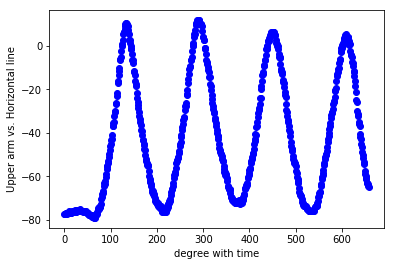

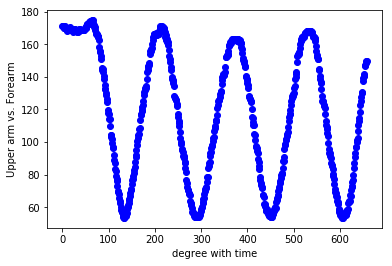

In [5]:
plt.plot(upper_arm,'bo')
plt.ylabel('Upper arm vs. Horizontal line')
plt.xlabel('degree with time')
plt.show()

plt.plot(between_arm,'bo')
plt.ylabel('Upper arm vs. Forearm')
plt.xlabel('degree with time')
plt.show()

In [6]:
#print(body_angle)
#img = cv2.imread(index_count[3]);
#plt.imshow(img)
#plt.show()

In [7]:
# try to deal with each action seperately
feedbacks = []
seperate_point = []


####
# to store the frame of wrong action
feedbacks_image = []
####


import peakutils
aa= -np.array(upper_arm)
seperate_points = peakutils.indexes(aa, min_dist=100)
print('seperating points are:', seperate_points)

for index_x in range(0,len(seperate_points)-1):
    print(index_x)
    feedback_temp = ['None','None','None','None','None','None']
    feedback_image_temp = ['None','None','None','None','None','None']
    
    test_body_angle = body_angle[ seperate_points[index_x] :  seperate_points[index_x+1]]
    test_upper_arm = upper_arm[ seperate_points[index_x] :  seperate_points[index_x+1]]
    test_between_arm = between_arm[ seperate_points[index_x] :  seperate_points[index_x+1]]
    time = (seperate_points[index_x+1] - seperate_points[index_x])/60
    
    
    #first module
    if (test_body_angle[60] > 20):
        feedback_temp[0]=("Warning:You didn't keep your back paralle to the ground!")
    
    max_body_angle = max(test_body_angle)
    max_index = body_angle.index(max_body_angle)
    min_body_angle = min(test_body_angle)
    min_index = body_angle.index(min_body_angle)
    if (max_body_angle - min_body_angle > 10):
        feedback_temp[1]=("Keep your body fixed! Do not shake!")
        
    #second module   
    max_upper_arm = max(test_upper_arm)
    max_index = upper_arm.index(max_upper_arm)
    if (max_upper_arm < 10):
        feedback_temp[2]=("You should lift the dumbbell higher!")
        feedback_image_temp[2]=index_count[max_index]
    
    #third module
    max_between_arm = max(test_between_arm)
    max_index = between_arm.index(max_between_arm)
    min_between_arm = min(test_between_arm)
    min_index = between_arm.index(min_between_arm)
    if (min_between_arm < 40):
        feedback_temp[3]=("The angle between your upper arm and forearm is too small!")
        feedback_image_temp[3]=index_count[min_index]
    elif (min_between_arm > 80):
        feedback_temp[3]=("The angle between your upper arm and forearm is too big!")
        feedback_image_temp[3]=index_count[min_index]
    else:
        pass
    
    if (max_between_arm < 160):
        feedback_temp[4]=("You should put the dumbbell lower to let your muscle stretch more!")
        feedback_image_temp[4]=index_count[max_index]
    else:
        pass
    
    #fourth module            
    if time < 2.5:
        feedback_temp[5] = "Too fast!" 
            
    feedbacks.append(feedback_temp)
    feedbacks_image.append(feedback_image_temp)   

seperating points are: [ 66 215 380 536 654]
0
1
2
3


In the 1 turn, you have several problems:
Too fast!
~~~~~~~~~~~~~~~~~~~~~~
In the 2 turn, you have several problems:
~~~~~~~~~~~~~~~~~~~~~~
In the 3 turn, you have several problems:
 You should lift the dumbbell higher!


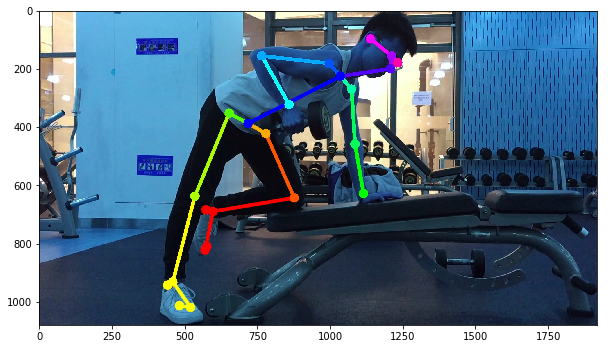

~~~~~~~~~~~~~~~~~~~~~~
In the 4 turn, you have several problems:
 You should lift the dumbbell higher!


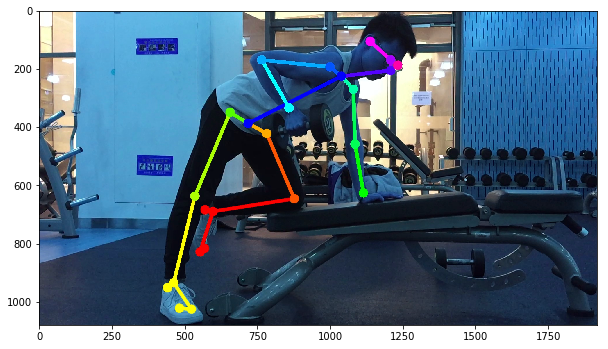

Too fast!
~~~~~~~~~~~~~~~~~~~~~~


In [8]:
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 6.0)
for each_x in range(len(seperate_points)-1):
    print("In the "+ str(each_x+1) +" turn, you have several problems:")
    feedback = feedbacks[each_x]
    image_part = feedbacks_image[each_x]
    if feedback == ['None','None','None','None','None','None']:
        print('Good Jobs!!!!!')
    else:
        for each_y in range(len(feedback)):
            if feedback[each_y] != 'None':
                
                if image_part[each_y] != 'None':
                    print('\033[1;35m',feedback[each_y])
                    #print(image_part[each_y])
                    
                    img = cv2.imread(image_part[each_y]);
                    plt.imshow(img)
                    plt.show()
                else:
                    print(feedback[each_y])

    print('~~~~~~~~~~~~~~~~~~~~~~')
        


In [9]:
print(feedbacks_image)

[['None', 'None', 'None', 'None', 'None', 'None'], ['None', 'None', 'None', 'None', 'None', 'None'], ['None', 'None', 'output_video/dumbbell_rowing_true/0452.jpg', 'None', 'None', 'None'], ['None', 'None', 'output_video/dumbbell_rowing_true/0608.jpg', 'None', 'None', 'None']]
